In [1]:
import numpy as np
import theano 
import theano.tensor as T
import matplotlib.pyplot as plt
import math 
from scipy.io import loadmat 
from sklearn.feature_extraction.image import PatchExtractor
from theano.compat.python2x import OrderedDict
%matplotlib inline

In [2]:
data = loadmat("IMAGES.mat")

In [3]:
ims = np.transpose(data['IMAGES'], (2,0,1))

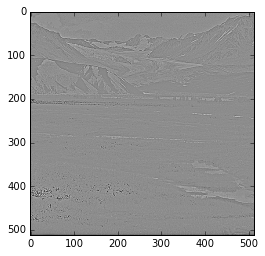

In [4]:
plt.imshow(ims[9], cmap = 'gray') 
plt.show()

In [5]:
shape = (8,8)
dim = np.prod(shape)
patches = PatchExtractor(shape, 64*64).transform(ims)
patches = patches.reshape(-1,dim)

In [6]:
patches.shape

(40960, 64)

# starting theano

In [39]:
n_batch = 100
n_iter = 150
nneurons = 1*dim 
# 1 will change 
x = theano.shared(np.zeros((n_batch,dim)))
w = theano.shared(np.random.randn(nneurons,dim))
a = theano.shared(np.zeros((n_batch,nneurons)))
x_batch = T.matrix() 
lam = .1 
eps = 1

In [40]:
costfunction = (.5*(x-T.dot(a,w))**2).sum(axis=1).mean() + lam*abs(a).sum(axis=1).mean() 
grad_a = T.grad(costfunction,a) 
grad_w = T.grad(costfunction,w)

In [41]:
# first function will zero out the a's 
# step_a will begin gradiant descent on a
# step_w will begin gradient descent on w 
updates = OrderedDict()
updates[a] = 0.*a 
zero_a = theano.function([],[],updates = updates)
updates = OrderedDict()
updates[a] = a - eps*grad_a 
step_a = theano.function([],[costfunction],updates = updates)
updates = OrderedDict()
updates[x] = x_batch
update_x = theano.function([x_batch],[],updates = updates) 
updates = OrderedDict()
updates[w] = w - eps*grad_w 
step_w = theano.function([],[costfunction],updates = updates) 

In [42]:
for ii in range(int(math.ceil(1.*patches.shape[0]/n_batch))):
    zero_a()
    update_x(patches[ii*n_batch : (ii+1)*n_batch])
    for jj in range(n_iter):
        cost = step_a() 
        print cost 
    break
    

[array(3.262098707994989)]
[array(1.855562346879746)]
[array(1.5404527003293405)]
[array(1.426363766729505)]
[array(1.4020839523210293)]
[array(1.4530710577392874)]
[array(1.5782245663104337)]
[array(1.805342821811001)]
[array(2.1685693921439566)]
[array(2.7417122077042966)]
[array(3.6153882061034963)]
[array(4.955096088728171)]
[array(6.986953493258854)]
[array(10.091518835286976)]
[array(14.79493269754883)]
[array(21.971073306005046)]
[array(32.85620165028827)]
[array(49.436590346058864)]
[array(74.62610963561796)]
[array(112.97419549543262)]
[array(171.27386179093835)]
[array(259.98620254760766)]
[array(394.9075393301361)]
[array(600.2013561389277)]
[array(912.5055127166647)]
[array(1387.7349811988393)]
[array(2110.8006141497444)]
[array(3211.1494140235814)]
[array(4885.568756023868)]
[array(7433.826450750161)]
[array(11311.932257281935)]
[array(17214.236262318835)]
[array(26197.328739369616)]
[array(39869.749909466205)]
[array(60679.580446510765)]
[array(92353.44692062313)]
[array(